# Virtual Day at Schack

## What Use is Data Analytics?

### Theory to Practice to Answering Interesting Questions

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime as dt  
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import patsy
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import warnings
warnings.simplefilter('ignore')
import yfinance as yf
from IPython.display import Image
import theano
import pymc3 as pm

Populating the interactive namespace from numpy and matplotlib


## The Capital Asset Pricing Model



$E(r_i)-r_f = \alpha + \beta \cdot (E(r_m)-r_f)$



#### Phrases you may have heard



* The stock's beta is high
* The hedge fund is chasing alpha

### Teaching in a Sea of These

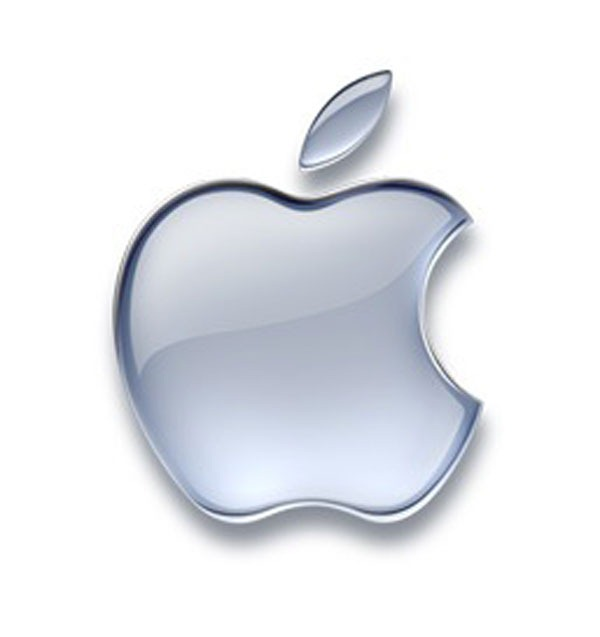

In [2]:
url = 'http://buzzmybiz.co/wp-content/uploads/2012/06/apple-logo.jpg'
Image(url, width=400, height=400)

In [3]:
# Grab Apple and NASDAQ data.  

start, end = "2010-4-25", "2020-4-25"

aapl_all = yf.download('aapl', start=start)
nasdaq_all = yf.download('^ixic', start=start)
aapl = aapl_all['Adj Close']
nasdaq = nasdaq_all['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'AAPL ($/Share)')

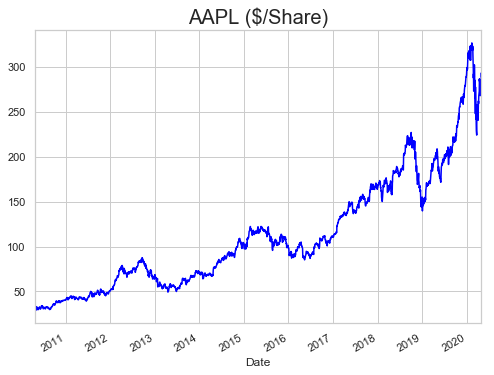

In [4]:
plt.figure(figsize=(8, 6))
aapl.plot(color='blue')
plt.title('AAPL ($/Share)', fontsize=20)

Text(0.5, 1.0, 'NASDAQ Index')

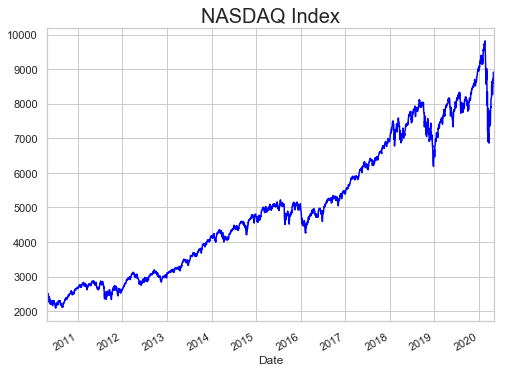

In [5]:
plt.figure(figsize = (8, 6))
nasdaq.plot(color='blue')
plt.title('NASDAQ Index', fontsize=20)

In [6]:
# Calculate log returns, which is the standard finance measure for daily returns in finance.

aapl_returns = (np.log(aapl / aapl.shift(1))).dropna()
nasdaq_returns = (np.log(nasdaq / nasdaq.shift(1))).dropna()

(0, 60)

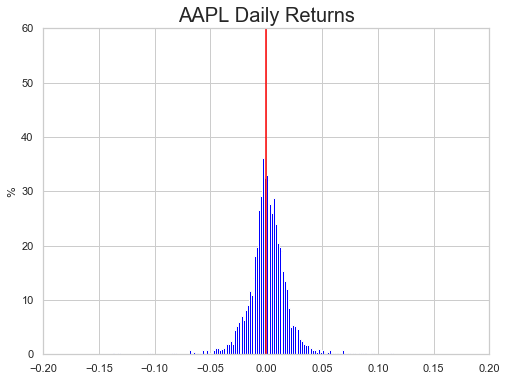

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(aapl_returns, bins=150, density=True, color='blue')
plt.title('AAPL Daily Returns', fontsize=20)
plt.ylabel('%', fontsize=12)
plt.axvline(0, color='red')
plt.xlim(-0.2, 0.2)
plt.ylim(0, 60)

(0, 60)

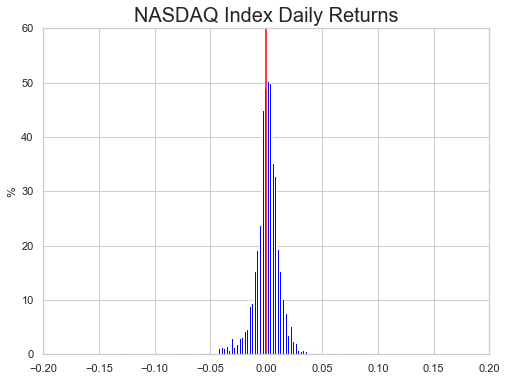

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(nasdaq_returns, bins=150, density=True, color='blue')
plt.title('NASDAQ Index Daily Returns', fontsize=20)
plt.ylabel('%', fontsize=12)
plt.axvline(0, color='red')
plt.xlim(-0.2, 0.2)
plt.ylim(0, 60)

In [9]:
aapl_returns = pd.DataFrame(aapl_returns)
nasdaq_returns = pd.DataFrame(nasdaq_returns)

(-0.1, 0.1)

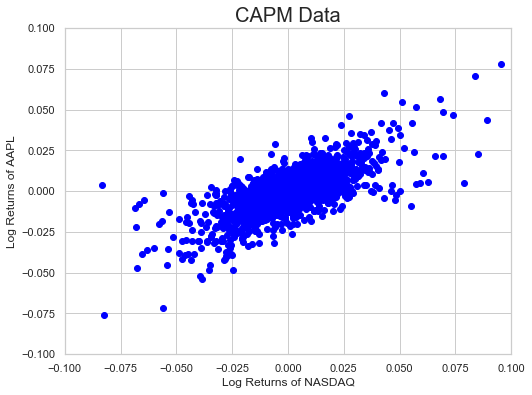

In [10]:
plt.figure(figsize = (8, 6))
plt.scatter(aapl_returns, nasdaq_returns, c='blue')
plt.title('CAPM Data', fontsize = 20)
plt.xlabel('Log Returns of NASDAQ', fontsize = 12)
plt.ylabel('Log Returns of AAPL', fontsize = 12)
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])



In [11]:
aapl_r = pd.DataFrame(aapl_returns)
nasdaq_r = pd.DataFrame(nasdaq_returns)
data = pd.merge(nasdaq_r, aapl_r, left_index=True, right_index=True)
data.rename(columns={'Adj Close_x':'nasdaq', 'Adj Close_y':'aapl'}, inplace=True)
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     2776.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        08:24:48   Log-Likelihood:                 7568.7
No. Observations:                2522   AIC:                        -1.513e+04
Df Residuals:                    2520   BIC:                        -1.512e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004      0.000      1.476      0.1

(-0.1, 0.1)

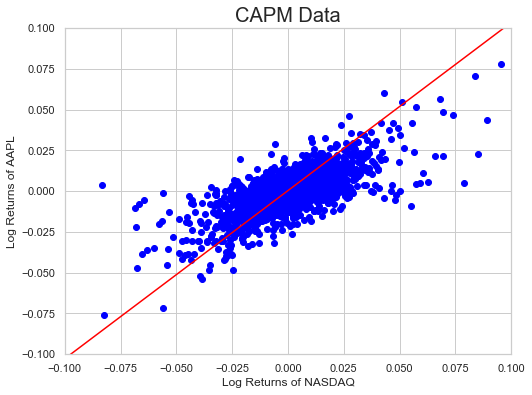

In [12]:
figure, ax = plt.subplots(figsize=(8, 6))
ax.scatter(aapl_returns, nasdaq_returns, c="blue")
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('CAPM Data', fontsize = 20)
ax.set_ylabel('Log Returns of AAPL', fontsize = 12)
ax.set_xlabel('Log Returns of NASDAQ', fontsize = 12)
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])

## Can We Earn $\alpha$ Without Bearing $\beta$?



**CAPM**: $E(r_i)-r_f = \alpha + \beta \cdot (E(r_m)-r_f)$


Express the idea probabilistically as Pr($\alpha > 0$ and $\beta \le 1$)


Using real-world data, simulation and Bayesian inference, we can evaluate this probability directly

In [19]:
with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta * nasdaq_returns
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=aapl_returns)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = 7,558.6, ||grad|| = 2.4607: 100%|██████████| 23/23 [00:00<00:00, 2223.30it/s]   
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 617.96draws/s] 


<Figure size 720x720 with 0 Axes>

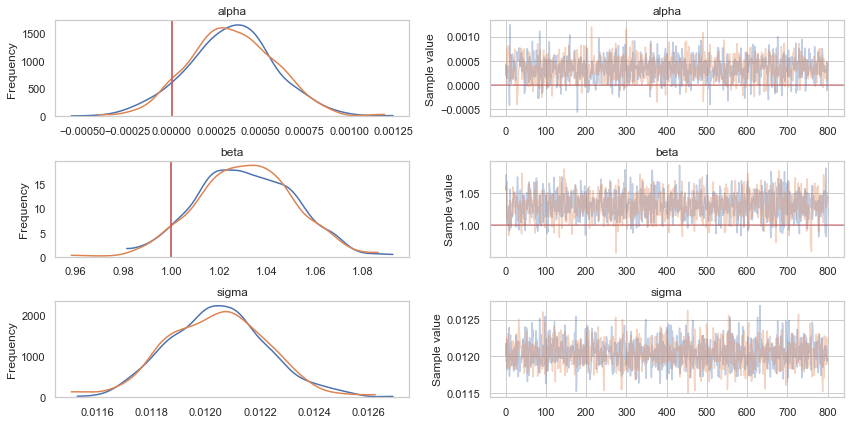

<Figure size 720x720 with 0 Axes>

In [20]:
fig = pm.traceplot(trace[199:1000], lines={'alpha': 0, 'beta': 1})
plt.figure(figsize = (10, 10))

In [21]:
print ("The probability that alpha is greater than zero is %f" % np.mean(trace['alpha'][199:1000] > 0.0))
print ("The probability that beta is less than one is %f" % np.mean(trace['beta'][199:1000] < 1.0))
print ("The joint probability is %f" % np.all([[trace['alpha'][199:1000] > 0.0], [trace['beta'][199:1000] <= 1.0]], axis = 0).mean())

The probability that alpha is greater than zero is 0.911361
The probability that beta is less than one is 0.058677
The joint probability is 0.051186


## Can We Earn $\alpha$ Without Bearing $\beta$?



Pr($\alpha > 0$ and $\beta \le 1$) $\approx$ 5.1%

# The Current Climate



## Uncertainty $\approx$ Lack of Data

In [16]:
covid = pd.read_csv('https://covidtracking.com/api/us/daily.csv')
covid['date'] = pd.to_datetime(covid['date'], format='%Y%m%d')
covid = covid.sort_values('date')
covid['rate'] = covid['positive'] / covid['posNeg'] * 100
covid = covid.iloc[45:]

(array([737492., 737499., 737506., 737513., 737516., 737523., 737530.,
        737537., 737544., 737546.]), <a list of 10 Text xticklabel objects>)

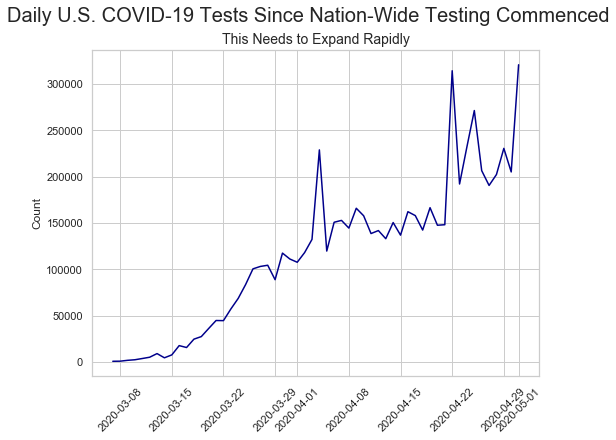

In [17]:
plt.figure(figsize=(8, 6))
plt.title('This Needs to Expand Rapidly', fontsize=14)
plt.suptitle('Daily U.S. COVID-19 Tests Since Nation-Wide Testing Commenced', fontsize=20)
plt.plot(covid['date'], covid['totalTestResultsIncrease'], color='darkblue')
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
# source: https://covidtracking.com/api/us/daily.csv

(array([737492., 737499., 737506., 737513., 737516., 737523., 737530.,
        737537., 737544., 737546.]), <a list of 10 Text xticklabel objects>)

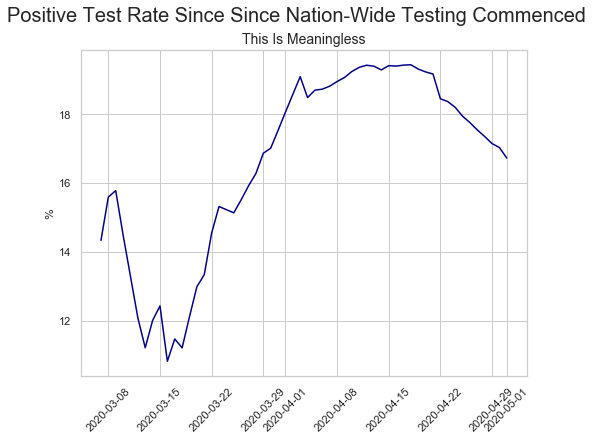

In [18]:
plt.figure(figsize=(8, 6))
plt.title('This Is Meaningless', fontsize=14)
plt.suptitle('Positive Test Rate Since Since Nation-Wide Testing Commenced', fontsize=20)
plt.plot(covid['date'], covid['rate'], color='darkblue')
plt.ylabel('%', fontsize=12)
plt.xticks(rotation=45)
# source: https://covidtracking.com/api/us/daily.csv and author's calculation

# Thank You